## Predicting Heart Disease

### Introduction:



According to the CDC, one person dies every 33 seconds from heart disease in the United States. Heart disease is a condition that affects the heart and blood vessels.Though there is no definite cure, it is possible to alleviate symptoms and prevent the condition from worsening and becoming fatal via lifestyle changes and medications. The question we will be answering is: Can we predict the severity of heart disease in a patient based on health measurements taken in the hospital? We will be using the “Heart Disease'' dataset from the UC Irvine Machine Learning Repository which provides health and lifestyle characteristics of patients, and whether the patient is diagnosed with heart disease as well as its severity, ranging from 0 (no presence) to 4. 

**Predictive Question**: Can we predict the severity of heart disease in a patient based on health measurments taken in the hospital?

**Dataset**: Heart Disease Dataset. It has 14 variables:

- Age: Years
- Sex : 1 = male , 0 = female
- cp :  chest pain type
- trestbps : resting blood pressure (mm Hg)
- chol :  serum cholesterol (mg/dl)
- fbs :   fasting blood sugar   ( 1: fbs >120mg/dl, 0 : fbx <120 mg/dl)
- Restecg : resting electrocardiographic results
- Thalach : maximum heart rate achieved
- exang :  exercise induced angina 
- Oldpeak : ST depression induced by exercise relative to rest
- Slope : slope of the peak exercise ST segment ( 1: upsloping, 2: flat,  downsloping)
- ca :   number of major vessels (0-3) colored by fluoroscopy
- Thal : normal, fixed defect, reversible defect
- Num :  Level of heart disease 

Other characteristics:
There is some missing data in the dataset. 


### Preliminary Exploratory Data Analysis:

In [1]:
### Loading the relevant libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

set.seed(1234)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.6     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#Reading the data from Github

#URl of the raw clevland.data file 
url <- "https://raw.githubusercontent.com/sachit-sharma/dsci-100-group-project-group53/main/processed.cleveland.data"
column_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldspeak", "slope", "ca", "thal", "num")

heart_disease_data <- read_csv(url, col_names = column_names) |>
                       mutate (sex = as.factor(sex), 
                              thal = as.factor(thal), 
                              num = as.factor(num), 
                              cp = as.factor(cp), 
                              fbs = as.factor(fbs), 
                              restecg = as.factor(restecg), 
                              exang = as.factor(exang), 
                              ca = as.factor(ca),
                              slope = as.numeric(slope), 
                               trestbps = as.numeric(trestbps), 
                               chol = as.numeric(trestbps),
                               oldspeak = as.numeric(oldspeak), 
                               thalach = as.numeric(thalach))|>
                               rename(class = num)
#Changing all ? to NA
heart_disease_data[ heart_disease_data == "?"] <- NA 

#Removing all nas for the predictors
heart_disease_data <- heart_disease_data |>
                      filter(!is.na(age), !is.na(thalach), !is.na(chol), !is.na(trestbps), !is.na(oldspeak), !is.na(slope))


#Splitting the data into training and testing
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = class)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

head(heart_disease_data)

Rows: 626 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): trestbps, chol, fbs, restecg, thalach, exang, oldspeak, slope, ca,...
dbl  (4): age, sex, cp, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There were 4 warnings in `mutate()`.
The first warning was:
ℹ In argument: `slope = as.numeric(slope)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings.”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldspeak,slope,ca,thal,class
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
63,1,1,145,145,1.0,2.0,150,0.0,2.3,3,0.0,6.0,0
67,1,4,160,160,0.0,2.0,108,1.0,1.5,2,3.0,3.0,2
67,1,4,120,120,0.0,2.0,129,1.0,2.6,2,2.0,7.0,1
37,1,3,130,130,0.0,0.0,187,0.0,3.5,3,0.0,3.0,0
41,0,2,130,130,0.0,2.0,172,0.0,1.4,1,0.0,3.0,0
56,1,2,120,120,0.0,0.0,178,0.0,0.8,1,0.0,3.0,0


In [3]:
#Calculating the mean value of the predictors 

heart_disease_select <-  heart_disease_train |>
                         select(age, trestbps, chol, thalach)

mean_values <- heart_disease_select |>
               map_df(mean, na.rm = TRUE)
mean_values

age,trestbps,chol,thalach
<dbl>,<dbl>,<dbl>,<dbl>
55.93386,130.963,130.963,140.2037


The mean value of the predictors we are using are:

- Age : 56.3
- Tresbps (Resting Blood Pressure) : 131 mm of Hg
- Serum Cholestrol :131.62 mg/dl
- Thalach (Maximum Heart Rate) : 136.7 bpm

In [4]:
#Calculating the max of the predictors 

max_obs <-  heart_disease_select |>
            map_df(max, na.rm = TRUE)
max_obs


age,trestbps,chol,thalach
<dbl>,<dbl>,<dbl>,<dbl>
77,200,200,195


The max value of the predictors we are using are:

- Age : 77
- Tresbps (Resting Blood Pressure) : 200 mm of Hg
- Serum Cholestrol :131.62 mg/l
- Thalach (Maximum Heart Rate) : 136.7 bpm

In [5]:
#Calculating the min of the predictors 
min_obs <- heart_disease_select |>
           map_df(min, na.rm = TRUE)

min_obs

age,trestbps,chol,thalach
<dbl>,<dbl>,<dbl>,<dbl>
34,0,0,63


These are the minimum values of all predictors. On scrutiny, there is only one observatoin with cholestrol = 0 and trestbps = 0. It seems like this is a faulty observation and should be removed

In [6]:

#Calculating the distribution of classes 

class_pct <- heart_disease_train |> 
             group_by(class) |>
             summarize(percentage = n()*100/nrow(heart_disease_train))
class_pct 

class,percentage
<fct>,<dbl>
0,37.037037
1,24.338624
2,17.460317
3,15.873016
4,5.291005




It is clear that the class 0 (absence of disease)is in the majority in the data set. The next most observed class is the presence of the lowest level of heart disease. Heart disease of level  4 is the least common in our data set. If a majority classifier was used, then it would only have a 35.04% accuracy. Our data set is well balanced with the distribution of classes, but we would may need to do oversampling for the class 4,2,3. 

In [7]:
#counting the number of NAs

heart_disease_select |> summarize( na_age = sum(is.na(age)),
                                   na_chol = sum(is.na(chol)),
                                  na_trespbs = sum(is.na(trestbps)), 
                                  na_thalach = sum(is.na(thalach)))

nrow(heart_disease_train)

na_age,na_chol,na_trespbs,na_thalach
<int>,<int>,<int>,<int>
0,0,0,0


[1] 378

In the training data set, the number of NAs in the predictor variables is significant, but in comparison to the total number of data points, it is not a big problem. We can still use them as predictors.


#### Preliminary Graphic Analysis ####

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



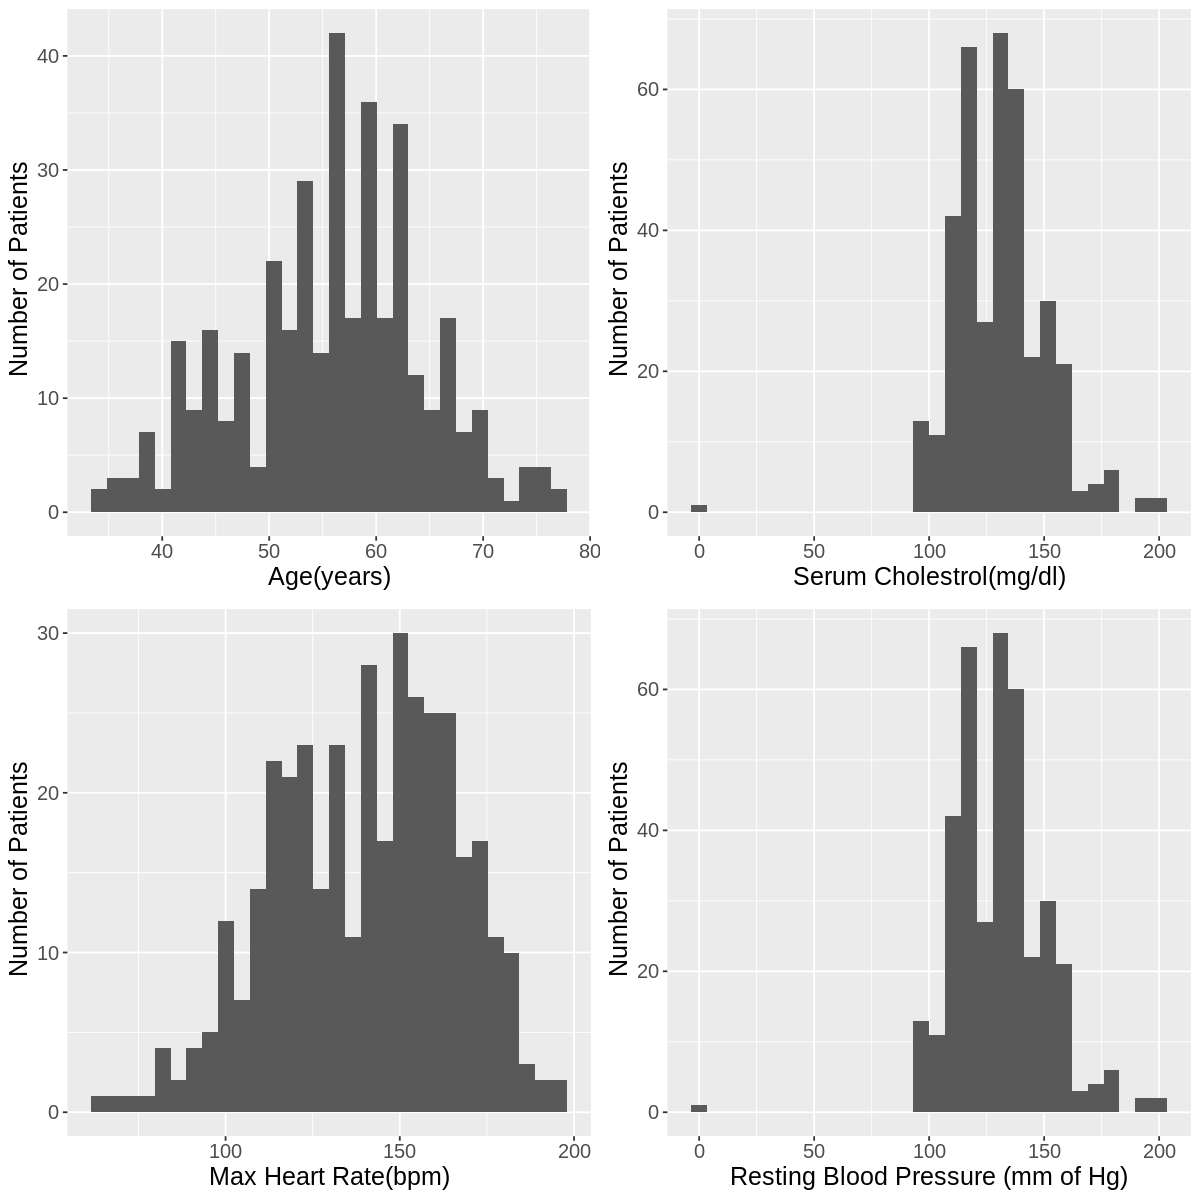

In [8]:
options(repr.plot.width = 10, repr.plot.height = 10)

age_hist <- ggplot(heart_disease_train, 
                      aes(x = age)) +
  geom_histogram() +
  labs(x = "Age(years)", 
       y = " Number of Patients") +
  theme(text = element_text(size = 15))

chol_hist <- ggplot(heart_disease_train, 
                      aes(x = chol)) +
  geom_histogram() +
  labs(x = "Serum Cholestrol(mg/dl)", 
       y = " Number of Patients") +
  theme(text = element_text(size = 15))

thalach_hist <- ggplot(heart_disease_train, 
                      aes(x = thalach)) +
  geom_histogram() +
  labs(x = "Max Heart Rate(bpm)", 
       y = " Number of Patients") +
  theme(text = element_text(size = 15))

bp_hist <- ggplot(heart_disease_train, 
                      aes(x = trestbps)) +
  geom_histogram() +
  labs(x = "Resting Blood Pressure (mm of Hg)", 
       y = " Number of Patients") +
  theme(text = element_text(size = 15))

plot_grid(age_hist,chol_hist,thalach_hist,bp_hist)

The above plots show the distribution of the predictor variables in the data set. 

### Methods:

Having many predictors is good, but it is important to ensure they are relevant. Irrelevant predictors add noise and decrease accuracy.

#### Reasons for chosing the predictors 
The predictors we will use are age, serum cholesterol (chol), maximum heart rate achieved (thalach), and resting blood pressure (trestpbps). We chose these because of a combination of scientific research and our own intuition of what contributes to heart disease. 

- **Age**: According to the American Heart Association (AHA), the incidence of heart disease in US mean and women is ~40% from 40-59 years, ~75% from 60-79 years and ~86% in those above the age of 80. This suggests that old age can be a significant factor towards predicting heart disease (Rodgers et al.,2019)

- **Cholestrol (chol)**: According to the study conducted by Jung et al.(2022), high serum cholesterol, which is composed of both high-density lipoprotein(HDL) and low-density lipoprotein(LDL), is shown to be associated with an increased mortality due to heart disease. As a result high cholestrol levels, can be a good predictor for high levels of heart disease. 

- **Maximum Heart Rate (thalach)** : A study by Peter-Guillaume et al.(2009)  found that high heart rate was a signifcant factor for cardiovasuclar disease. The study found that high heart rate was also associated with other risk factors for heart disease such as high blood pressure. As a result, we can expect high heart rate to be a predictor of high levels of heart disease. 

- **Resting Blood Pressure (trestpbs)** : Wu et al.(2015) found that stage 2-3 hypertension( blood presure >140 mm Hg) was associated with increased risk of cardiovascular disease and mortality among older adults. Thus, it can also serve as a good predictor. 

All four variables are significant so they will be predictors. 

There are many ways to make predictions for classification problems but we will use the K-nearest-neighbors algorithm. Through the steps of visualizing, evaluating, and tuning our data, we will attempt to accurately predict the severity of heart disease. 

We will use a scatter plot of the standardized predictors in order to visualize trends in severity of heart disease compared to our variables. 

We are using the K-neighbors algorithm so we will be making a combined scatter and line plot comparing  “neighbors” to “estimated accuracy”. This allows us to find the optimal k value which yields the best accuracy. 


References

1. Rodgers, J. L., Jones, J., Bolleddu, S. I., Vanthenapalli, S., Rodgers, L. E., Shah, K., ... & Panguluri, S. K. (2019). Cardiovascular risks associated with gender and aging. *Journal of cardiovascular development and disease, 6*(2), 19. https://doi.org/10.3390/jcdd6020019



### Expected Outcomes and Significance:

We expect to predict the severity of heart disease based on an individual’s physical health. We predict age, cholesterol levels, and resting blood pressure will be positively correlated to heart disease. Conversely, the maximum achievable heart rate will be negatively correlated with heart disease. These findings can help determine who may be at a higher risk of developing heart disease and prevent it. 

### Forward Selection

In [9]:
# Reference: https://datasciencebook.ca/classification2.html#forward-selection-in-r
#Creating the column names 

# heart_disease_select <- heart_disease_train |>
#                         select(age, chol, thalach, slope, oldspeak, trestbps, class)

# names <- colnames(heart_disease_select |> select(-class))

# # create an empty tibble to store the results
# accuracies <- tibble(size = integer(), 
#                      model_string = character(), 
#                      accuracy = numeric())

# # create a model specification
# knn_spec <- nearest_neighbor(weight_func = "rectangular", 
#                              neighbors = tune()) |>
#      set_engine("kknn") |>
#      set_mode("classification")

# # create a 5-fold cross-validation object
# heart_disease_vfold <- vfold_cv(heart_disease_select, v = 5, strata = class)

# # store the total number of predictors
# n_total <- length(names)

# # stores selected predictors
# selected <- c()

# # for every size from 1 to the total number of predictors
# for (i in 1:n_total) {
#     # for every predictor still not added yet
#     accs <- list()
#     models <- list()
#     for (j in 1:length(names)) {
#         # create a model string for this combination of predictors
#         preds_new <- c(selected, names[[j]])
#         model_string <- paste("class", "~", paste(preds_new, collapse="+"))

#         # create a recipe from the model string
#         heart_disease_recipe <- recipe(as.formula(model_string), 
#                                 data = heart_disease_recipe) |>
#                           step_scale(all_predictors()) |>
#                           step_center(all_predictors())

#         # tune the KNN classifier with these predictors, 
#         # and collect the accuracy for the best K
#         acc <- workflow() |>
#           add_recipe(heart_disease_recipe) |>
#           add_model(knn_spec) |>
#           tune_grid(resamples = heart_disease_vfold, grid = 10) |>
#           collect_metrics() |>
#           filter(.metric == "accuracy") |>
#           summarize(mx = max(mean))
#         acc <- acc$mx |> unlist()

#         # add this result to the dataframe
#         accs[[j]] <- acc
#         models[[j]] <- model_string
#     }
#     jstar <- which.max(unlist(accs))
#     accuracies <- accuracies |> 
#       add_row(size = i, 
#               model_string = models[[jstar]], 
#               accuracy = accs[[jstar]])
#     selected <- c(selected, names[[jstar]])
#     names <- names[-jstar]
# }
# accuracies

### Analysis of the Data

In [10]:
#Data Preprocessing

#Creating 5 folds for cross validations
heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = class)

#Creating the recipe and performing centering, scaling and upsampling. 

heart_disease_recipe <- recipe(class ~ trestbps + chol + trestbps + age, data = heart_disease_train) |>
                        step_center(all_predictors()) |>
                        step_scale(all_predictors()) 

#Creating the model specification for our knn classification model

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
        
#Creating a data frame for k values 
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))
heart_disease_recipe 
knn_spec



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Centering for: all_predictors()

• Scaling for: all_predictors()



K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [11]:
# Calculating the cross validation accuracy for all k values 
knn_results <- workflow() |>
               add_recipe(heart_disease_recipe) |>
               add_model(knn_spec) |>
               tune_grid(resamples = heart_disease_vfold, grid = k_vals)|>
               collect_metrics() |>
               filter(.metric == "accuracy")
knn_results            

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.2435195,5,0.025856596,Preprocessor1_Model01
2,accuracy,multiclass,0.2300059,5,0.021962565,Preprocessor1_Model02
3,accuracy,multiclass,0.2829028,5,0.009284782,Preprocessor1_Model03
4,accuracy,multiclass,0.3015458,5,0.010530548,Preprocessor1_Model04
5,accuracy,multiclass,0.3039287,5,0.017661661,Preprocessor1_Model05
6,accuracy,multiclass,0.3306485,5,0.018526631,Preprocessor1_Model06
7,accuracy,multiclass,0.3310062,5,0.024458803,Preprocessor1_Model07
8,accuracy,multiclass,0.3255230,5,0.017702464,Preprocessor1_Model08
9,accuracy,multiclass,0.3204050,5,0.025470198,Preprocessor1_Model09


List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 12
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

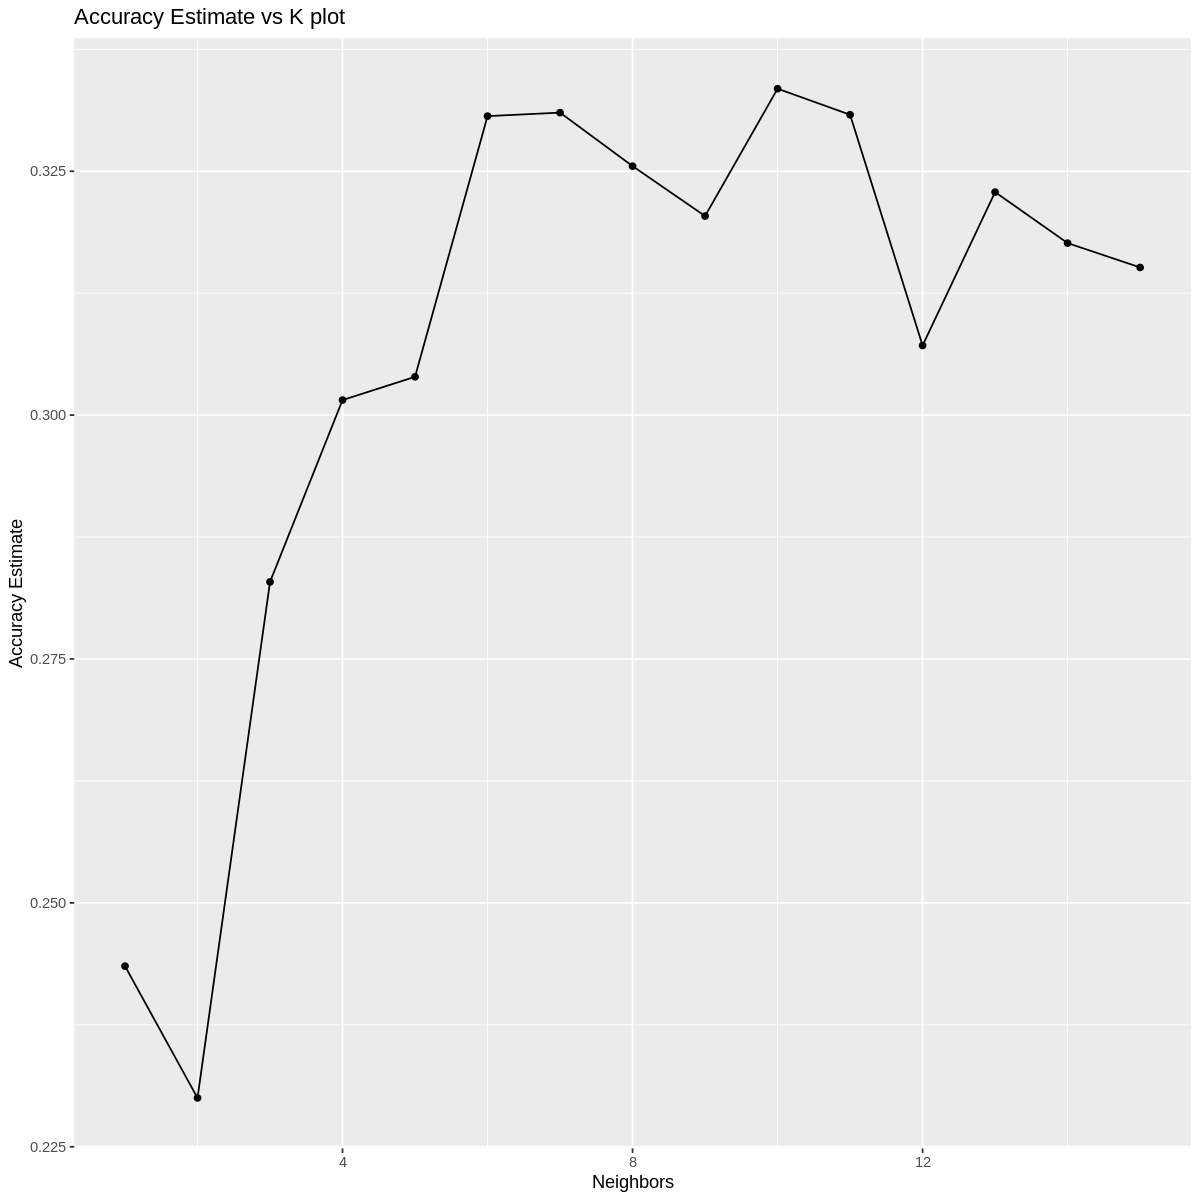

In [12]:
#Visualising the results using an accuracy estimate vs k plot 
accuracy_vs_k <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
  geom_point() + 
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  ggtitle("Accuracy Estimate vs K plot")
  theme(text = element_text(size = 12))
accuracy_vs_k 

In [13]:
#Finding the best k 
best_k <- knn_results  |>
          arrange(mean) |>
          slice(1) |>
          pull(neighbors)
best_k

[1] 2

In [20]:
#Retraining the model with best k 

knn_spec_best <- nearest_neighbor(weight_func = 'rectangular', neighbors = best_k) |>
                 set_engine("kknn") |>
                 set_mode("classification")

#Creating the workflow and fitting the model to the training dataset
knn_fit <- workflow() |>
           add_recipe(heart_disease_recipe) |>
           add_model(knn_spec_best) |>
           fit(data = heart_disease_train)  

#making the predictions and 
heart_disease_predictions <- knn_fit |>
                             predict(heart_disease_test) |>
                             bind_cols(heart_disease_test)

#computing the accuracy of the classifier


accuracy <- heart_disease_predictions |>
            metrics(truth = class, estimate = .pred_class)|>
            filter(.metric == "accuracy") 

heart_disease_predictions 

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldspeak,slope,ca,thal,class
<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
4,63,1,1,145,145,1.0,2.0,150,0.0,2.3,3,0.0,6.0,0
2,67,1,4,160,160,0.0,2.0,108,1.0,1.5,2,3.0,3.0,2
3,67,1,4,120,120,0.0,2.0,129,1.0,2.6,2,2.0,7.0,1
0,41,0,2,130,130,0.0,2.0,172,0.0,1.4,1,0.0,3.0,0
0,62,0,4,140,140,0.0,2.0,160,0.0,3.6,3,2.0,3.0,3
0,57,0,4,120,120,0.0,0.0,163,1.0,0.6,1,0.0,3.0,0
0,56,1,3,130,130,1.0,2.0,142,1.0,0.6,2,1.0,6.0,2
0,48,0,3,130,130,0.0,0.0,139,0.0,0.2,1,0.0,3.0,0
2,49,1,2,130,130,0.0,0.0,171,0.0,0.6,1,0.0,3.0,0


Confusion Matrix: 

In [33]:
conf_mat( heart_disease_predictions, truth = class, estimate = .pred_class)

num_classes <- heart_disease_predictions |>
               group_by(class) |>
               summarize(count = n())
num_classes

num_0 <- num_classes |> filter(class == 0) |> pull(count)
num_1 <- num_classes |> filter(class == 1) |> pull(count)
num_2 <- num_classes |> filter(class == 2) |> pull(count)
num_3 <- num_classes |> filter(class == 3) |> pull(count)
num_4 <- num_classes |> filter(class == 4) |> pull(count)

          Truth
Prediction  0  1  2  3  4
         0 28 16  9 10  0
         1  8  7  7  4  1
         2  7  3  3  2  2
         3  2  4  4  3  1
         4  2  3  0  1  0

class,count
<fct>,<int>
0,47
1,33
2,23
3,20
4,4


In [44]:
true_predictions <- heart_disease_predictions |> filter(class == .pred_class)
true_predictions

accuracy_predictions_by_class <- heart_disease_predictions |>
                                 select(.pred_class, class) |>
                                 filter(class == .pred_class) |>
                                 group_by(class) |>
                                 summarize(count = n()) 
     
accuracy_predictions_by_class 

percentage_correct <-  


.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldspeak,slope,ca,thal,class
<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
2,67,1,4,160,160,0.0,2.0,108,1.0,1.5,2,3.0,3.0,2
0,41,0,2,130,130,0.0,2.0,172,0.0,1.4,1,0.0,3.0,0
0,57,0,4,120,120,0.0,0.0,163,1.0,0.6,1,0.0,3.0,0
0,48,0,3,130,130,0.0,0.0,139,0.0,0.2,1,0.0,3.0,0
0,58,0,1,150,150,1.0,2.0,162,0.0,1.0,1,0.0,3.0,0
0,59,1,3,150,150,1.0,0.0,157,0.0,1.6,1,0.0,3.0,0
0,44,1,2,130,130,0.0,2.0,188,0.0,0.0,1,0.0,3.0,0
0,65,0,3,155,155,0.0,0.0,148,0.0,0.8,1,0.0,3.0,0
0,53,0,4,130,130,0.0,2.0,143,0.0,0.4,2,0.0,3.0,0


class,count
<fct>,<int>
0,28
1,7
2,3
3,3


### Visualisation of Results